In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.util import random_noise
from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import time
import os
import copy

data_folder = os.path.abspath('./data')
image_folder = os.path.join(data_folder, 'TRANCOS')

print(image_folder)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() == False:
    print('\033[91m' + "You are training on CPU, are you sure you want to continue?" + '\033[0m')

torch.manual_seed(1)

/mnt/c/Users/Alix/Desktop/school/Semester_5/project-415/data/TRANCOS


In [2]:
# Hyperparameters
img_size = (224, 224, 3)
batch_size = 32

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 1

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [3]:
# data augmentation
csv = pd.read_csv(os.path.join(data_folder, 'train.csv'))
csv = pd.Series(csv.counts.values,index=csv.images).to_dict()
images = list(csv.keys())
labels = list(csv.values())

if len(images) != len(labels):
    raise ValueError("Image and label arrays do not have the same size in train dataset.")

for img, label in zip(images, labels):
    image0 = os.path.join(image_folder, img.rstrip('.jpg') + '-0.jpg')
    image1 = os.path.join(image_folder, img.rstrip('.jpg') + '-1.jpg')
    image2 = os.path.join(image_folder, img.rstrip('.jpg') + '-2.jpg')
    image3 = os.path.join(image_folder, img.rstrip('.jpg') + '-3.jpg')

    # if they already exist, no need to redo the data augmentation
    if os.path.exists(image0) and os.path.exists(image1) and os.path.exists(image2) and os.path.exists(image3):
        continue

    image = cv2.normalize(cv2.resize(plt.imread(os.path.join(image_folder, img)), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    plt.imsave(image0, image)
    plt.imsave(image1, np.fliplr(image))
    plt.imsave(image2, np.flipud(image))
    plt.imsave(image3, random_noise(image,var=0.2**2))
    

In [4]:
# dataset class

class CustomDataset(Dataset):
    def __init__(self, type):

        self.type = type
        csv = pd.read_csv(os.path.join(data_folder, self.type + '.csv'))

        if self.type == 'train' or self.type == 'valid':
            csv = pd.Series(csv.counts.values,index=csv.images).to_dict()

            # getting the images 
            self.images = []
            self.labels = []
            images = list(csv.keys())
            labels = list(csv.values())
            if len(images) != len(labels):
                raise ValueError("Image and label arrays do not have the same size.")
            
            if self.type == 'valid':
                self.images = [os.path.join(image_folder, img) for img in images]
                self.labels = labels
            else:
                for img, label in zip(images, labels):
                    # adding augmented data to list
                    for i in range(4):
                        self.images.append(os.path.join(image_folder, img.rstrip('.jpg') + '-' + str(i) + '.jpg'))
                        self.labels.append(label)

            if len(self.images) != len(self.labels):
                raise ValueError("Image and label arrays do not have the same size or some values in these arrays are None.")

        elif self.type == 'test':

            # getting the images
            self.images = list(csv.images.values.tolist())

        else:
            raise ValueError("Invalid type in dataset. It has to have one of the following values: 'train', 'valid', 'test'.")
        print("Initiated " + self.type + " dataset of size " + str(len(self.images)) + " and images of shape " + str(list(img_size)))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        if self.type == 'test':
            return cv2.normalize(cv2.resize(plt.imread(os.path.join(image_folder, self.images[i])), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), self.images[i]
        else:
            return cv2.normalize(cv2.resize(plt.imread(self.images[i]), img_size[:2]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), self.labels[i]

In [5]:
# declaring datasets and data loaders

train_dataset = CustomDataset('train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomDataset('valid')
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset('test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Initiated train dataset of size 2492 and images of shape [224, 224, 3]
Initiated valid dataset of size 200 and images of shape [224, 224, 3]
Initiated test dataset of size 421 and images of shape [224, 224, 3]


In [6]:
# model
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 224

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, num_classes))

    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft = model_ft.to(device)

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

PyTorch Version:  1.10.0+cu102
Torchvision Version:  0.11.1+cu102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [7]:
# training
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_loss = []
    validation_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000000000000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    inputs = inputs.permute(0,3,1,2) # remap the inputs at the good spot
                    outputs = model(inputs)
                    loss = criterion(outputs[:,0], labels.float()) # cast the output as a 1D tensor and the inputs as float

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
                
            if phase == 'val':
                validation_loss.append(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                
            elif phase == 'train':
                train_loss.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print("Best validation loss: " + str(min(validation_loss)))
    return model, train_loss, validation_loss


params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Setup the loss fxn
# criterion = nn.CrossEntropyLoss()
loss = nn.MSELoss()

dataloaders = {'train': train_loader, 'val':valid_loader}

# Train and evaluate
model_ft, train_hist, valid_hist = train_model(model_ft, dataloaders, loss, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias
	 classifier.6.3.weight
	 classifier.6.3.bias
Epoch 0/99
----------
train Loss: 385.2614
val Loss: 93.9533
Epoch 1/99
----------
train Loss: 162.0930
val Loss: 116.1489
Epoch 2/99
----------
train Loss: 147.8317
val Loss: 100.5813
Epoch 3/99
----------
train Loss: 141.6309
val Loss: 77.0626
Epoch 4/99
----------
train Loss: 138.7238
val Loss: 87.4523
Epoch 5/99
----------
train Loss: 135.2204
val Loss: 74.8891
Epoch 6/99
----------
train Loss: 131.0338
val Loss: 71.4366
Epoch 7/99
----------
train Loss: 126.9560
val Loss: 104.6183
Epoch 8/99
----------
train Loss: 135.4029
val Loss: 78.5271
Epoch 9/99
----------
train Loss: 127.1047
val Loss: 73.0715
Epoch 10/99
----------
train Loss: 126.3593
val Loss: 70.7239
Epoch 11/99
----------
train Loss: 123.9632
val Loss: 69.8456
Epoch 12/99
----------
train Loss: 124.4130
val Loss: 66.3362
Epoch 13/99
----------
train Loss: 119.1275
val Loss: 67.2264
Epoch 14/99
----------
train L

In [8]:
# saving model
PATH = './models/model.hdf5'
torch.save(model_ft, PATH)

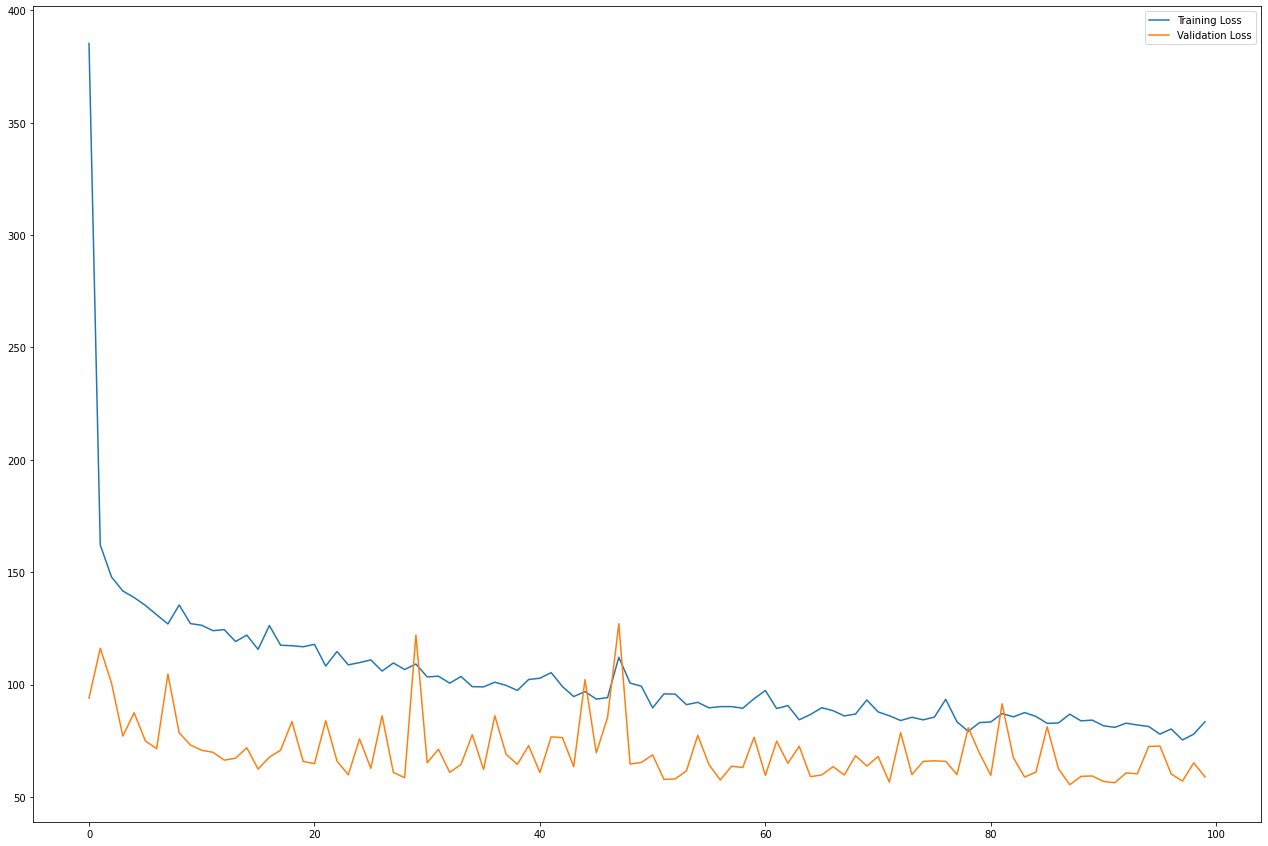

In [9]:
# training results
plt.gcf().set_size_inches(22, 15, forward=True)

plt.plot(train_hist, label='training loss')
plt.plot(valid_hist, label='validation loss')

plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [10]:
# calculating accuracy of model
import csv

model_ft.eval()

im_name = []
count = []
for inputs, name in test_loader:
    inputs = inputs.permute(0,3,1,2) # remap the inputs at the good spot
    inputs = inputs.to(device)
    outputs = model_ft(inputs)
    out_int = [int(item) for item in outputs[:,0].tolist()]
    count.extend(out_int)
    im_name.extend(name)

out = [['images'], ['counts']]
out[0].extend(im_name)
out[1].extend(count)

out2 = zip(*out)
out3 = list(out2)

with open('test_out.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    for x in out3:
        write.writerow(x)
    f.close()